<a href="https://colab.research.google.com/github/isegura/pln_tema0/blob/main/EDA_clasificacion_textos_binaria.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Análisis Exploratorio de un Dataset para Clasificación de Textos Binaria

Se asume que ya existen dos splists: train y test.


## 0. Cargar dataset

El dataset con el que vamos a trabajar es exist2021 (https://nlp.uned.es/exist2021/), una competición cuya objetivo era detectar tweets sexistas. Se propusieron dos tareas: task1 (clasificación binaria) y task2 (multiclasificación). En este notebook, nos centramos en analizar el dataset de la task1. El dataset se puede solicitar rellenando este [formulario](https://forms.office.com/e/ikGpvRQ1qv).

En la siguiente celda, cargamos los dos ficheros del dataset, train y test.


In [1]:
from google.colab import files
# Subir ficheros desde el ordenador
uploaded = files.upload()



Saving test.tsv to test.tsv
Saving train.tsv to train.tsv



Además:
- Como es un dataset multilingüe, únicamente nos quedaremos con los textos en inglés.
- Eliminamos las columnas que no vamos a usar (sólo necesitamos text y task1, que corresponde con la columna de la label para la tarea de clasificación binaria).
- Renombramos la columna task1 a label.

In [3]:
import pandas as pd
df_train = pd.read_csv("train.tsv",  sep='\t')
df_test = pd.read_csv("test.tsv",  sep='\t')
# mostramos algunos ejemplos del training
display(df_train.head(3))
# conservamos sólo textos en inglés
df_train=df_train[df_train['language']=='en']
df_test=df_test[df_test['language']=='en']
# eliminamos columnas
df_train = df_train.drop(['test_case', 'language', 'id', 'source', 'task2'], axis=1)
df_test = df_test.drop(['test_case', 'language', 'id', 'source', 'task2'], axis=1)
# renombramos task1 a label
df_train = df_train.rename(columns={'task1':'label'})
df_test = df_test.rename(columns={'task1':'label'})
df_train.head()

,test_case,id,source,language,text,task1,task2
0,EXIST2021,1,twitter,en,"She calls herself ""anti-feminazi"" how about sh...",sexist,ideological-inequality
1,EXIST2021,2,twitter,en,"Now, back to these women, the brave and the be...",non-sexist,non-sexist
2,EXIST2021,3,twitter,en,"@CurvyBandida @Xalynne_B Wow, your skirt is ve...",sexist,objectification


,text,label
0,"She calls herself ""anti-feminazi"" how about sh...",sexist
1,"Now, back to these women, the brave and the be...",non-sexist
2,"@CurvyBandida @Xalynne_B Wow, your skirt is ve...",sexist
3,@AurelieGuiboud Incredible! Beautiful!But I l...,non-sexist
4,i find it extremely hard to believe that kelly...,non-sexist


## 1. Inspección básica del dataset

In [4]:

print("Train size:", df_train.shape)
print("Test size:", df_test.shape)
df_train.head()
#display(df_train.head())
#display(df_test.head())



Train size: (3436, 2)
Test size: (2208, 2)


,text,label
0,"She calls herself ""anti-feminazi"" how about sh...",sexist
1,"Now, back to these women, the brave and the be...",non-sexist
2,"@CurvyBandida @Xalynne_B Wow, your skirt is ve...",sexist
3,@AurelieGuiboud Incredible! Beautiful!But I l...,non-sexist
4,i find it extremely hard to believe that kelly...,non-sexist


Con 3436 instancias, el tamaño del conjunto de entrenamiento es adecuado para modelos clásicos (logistic regression, SVM o Naive Bayes).
Sin embargo, para modelos de deep learning entrenados desde cero (por ejemplo, CNN o RNN sin word embeddings), este tamaño es limitado. La razón es que estos modelos tienen un número elevado de parámetros y requieren grandes volúmenes de datos para generalizar bien. El tamaño del dataset tiene una capacidad limitada de generalización, y un riesgo de sobreajuste rápido.

El tamaño podría ser razonable si:
- Se utilizan embeddings preentrenados (GloVe, fastText, Word2Vec).
- Se aplican técnicas de regularización fuertes (dropout, early stopping).
- La arquitectura es poco profunda y con pocos parámetros.


En el caso de modelos basados en Transformers, entrenarlos desde cero es inviable con este tamaño de datos. No obstante, si es posible hacer fine-tuning de modelos preentrenados (como BERT-base o variantes más ligeras), aunque con cuidado. Sería recomendable congelar capas iniciales o usar learning rates bajos para evitar sobreajuste.

## 2. Distribución de clases



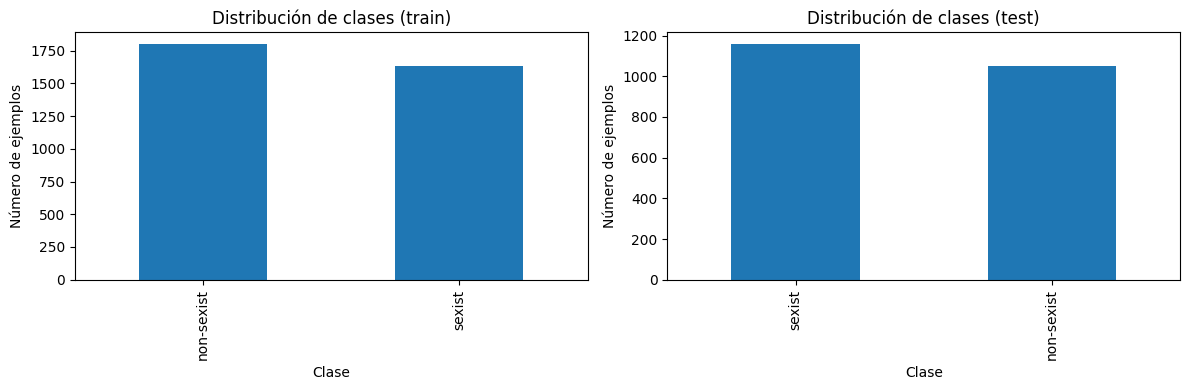

Distribución normalizada (train):
label
non-sexist    0.523865
sexist        0.476135
Name: proportion, dtype: float64

Distribución normalizada (test):
label
sexist        0.524457
non-sexist    0.475543
Name: proportion, dtype: float64


In [5]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

df_train['label'].value_counts().plot(kind='bar', ax=axes[0])
axes[0].set_title("Distribución de clases (train)")
axes[0].set_xlabel("Clase")
axes[0].set_ylabel("Número de ejemplos")

df_test['label'].value_counts().plot(kind='bar', ax=axes[1])
axes[1].set_title("Distribución de clases (test)")
axes[1].set_xlabel("Clase")
axes[1].set_ylabel("Número de ejemplos")

plt.tight_layout()
plt.show()

print("Distribución normalizada (train):")
print(df_train['label'].value_counts(normalize=True))

print("\nDistribución normalizada (test):")
print(df_test['label'].value_counts(normalize=True))



Siempre es necesario analizar (discutir) la distribución de clases:

La distribución de clases muestra un comportamiento muy equilibrado en ambos conjuntos:
- En el conjunto de entrenamiento, la clase non-sexist es ligeramente mayoritaria (≈52.4%), mientras que sexist representa alrededor del 47.6%. Esta diferencia es pequeña (∼4.8 puntos porcentuales), por lo que no existe un desbalance significativo que pudiera sesgar el aprendizaje del modelo.

- En el conjunto de test, ocurre lo contrario: la clase sexist pasa a ser ligeramente mayoritaria (≈52.4%) y non-sexist queda en ≈47.6%. De nuevo, la diferencia es mínima y muy similar en magnitud a la observada en train.

Desde el punto de vista metodológico, esto es una señal positiva:

- Las proporciones son muy similares entre train y test, lo que sugiere que la partición se realizó de forma adecuada (probablemente estratificada).
- No se espera que el modelo sufra problemas graves de generalización derivados de un cambio en la distribución de clases (label shift).

En resumen, el dataset está bien balanceado y bien particionado, con una variación leve y simétrica que es normal en divisiones aleatorias. Esto proporciona una base sólida para entrenar y evaluar modelos de clasificación sin necesidad inmediata de técnicas de re-balanceo.

## 3. Longitud de los textos (tokens)

Para obtener los textos, vamos a utilizar un enfoque muy sencillo como es dividir el txto con el método split(). Podríamos utilizar otros tokenizaciones más robustas (con spacy, un tokenizador de keras o algún tokenizador de un modelo transformer), pero split es suficiente para obtener una aproximación de la longitud de los textos.

En principio, sólo vamos a estudiar la distribución el training.
El conjunto test no debería influir en ninguna decisión sobre el diseño del modelo.


In [6]:

def token_length(text):
    return len(text.split())

df_train['n_tokens'] = df_train['text'].apply(token_length)
df_train['n_tokens'].describe(percentiles=[0.25, 0.5, 0.75, 0.9, 0.95, 0.99])


,n_tokens
count,3436.000000
mean,28.910652
std,16.225176
min,2.000000
25%,14.000000
50%,28.000000
75%,43.000000
90%,51.000000
95%,54.000000
99%,60.000000


Discutimos esa estadística:

- La distribución de tokens describe textos relativamente cortos, con una variabilidad moderada y una cola derecha clara.

- En primer lugar, el valor medio (≈28.9 tokens) y la mediana (28 tokens) son prácticamente idénticos. Esto indica que la distribución está bastante centrada y que los valores extremos no distorsionan de forma significativa la tendencia central.

- La desviación estándar (≈16.2 tokens) sugiere una variabilidad considerable: muchos textos se alejan de la media, lo cual es coherente con un conjunto que mezcla mensajes muy cortos con otros más largos.

- Los valores mínimos muestran la presencia de textos extremadamente breves (tan solo 2 tokens). Estos casos pueden aportar poca información semántica y conviene tenerlos en cuenta durante el preprocesamiento.

El análisis por percentiles refuerza la idea de una cola derecha:

- El 90% de los textos tiene ≤51 tokens
- El 95% no supera 54 tokens
- El 99% está por debajo de 60 tokens

Esto indica que los textos largos son raros, aunque existen, como refleja el máximo de 101 tokens. Estos valores extremos son poco frecuentes, pero duplican aproximadamente la longitud típica del corpus.

En conjunto, la distribución sugiere:

- Un corpus dominado por textos cortos y medianos
- Una longitud máxima acotada y manejable
- Un escenario favorable para modelos de lenguaje, ya que no se requieren secuencias largas

Desde un punto de vista práctico, estos resultados justifican fijar un límite de tokens entre 60 y 100 sin pérdida significativa de información, y sugieren revisar si los textos extremadamente cortos deberían filtrarse o tratarse de forma especial.

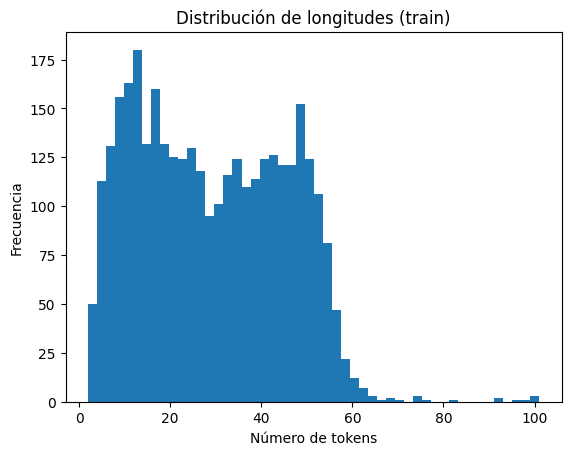

In [7]:

plt.hist(df_train['n_tokens'], bins=50)
plt.xlabel("Número de tokens")
plt.ylabel("Frecuencia")
plt.title("Distribución de longitudes (train)")
plt.show()


Este histograma muestra la distribución de longitudes de los textos (en número de tokens) del conjunto de entrenamiento, y refuerza muy bien lo que ya se observaba en las estadísticas descriptivas.

En primer lugar, se aprecia claramente que la mayoría de los textos se concentran en un rango bajo–medio de tokens, aproximadamente entre 10 y 50 tokens.

La distribución presenta una asimetría positiva (cola derecha):
- A partir de los 50–60 tokens, la frecuencia cae de forma abrupta.
- Existen textos largos (hasta ~100 tokens), pero son muy poco frecuentes y aparecen como valores aislados en la cola.

Esto confirma que los textos largos son outliers, coherentes con los percentiles altos (95%, 99%) vistos anteriormente.

También se intuye una estructura multimodal suave o pequeñas ondulaciones en la zona central (por ejemplo, entre 15–20 y 35–45 tokens), lo que podría reflejar distintos tipos de mensajes: respuestas muy breves frente a explicaciones algo más elaboradas.

Desde un punto de vista práctico y de modelado:

- Para modelos clásicos, esta variabilidad no supone un problema importante.
- Para CNN/RNN, la distribución es favorable, ya que la mayoría de las secuencias son cortas y no requieren truncamientos agresivos.
- Para Transformers, el histograma justifica perfectamente fijar un máximo de longitud entre 60 y 100 tokens, ya que cubriría prácticamente todo el corpus sin desperdiciar capacidad computacional en padding innecesario.

En resumen, la imagen confirma que se trata de un corpus compacto, dominado por textos cortos, con una cola derecha pequeña pero controlada. Esto facilita el entrenamiento, simplifica el preprocesamiento y reduce los costes computacionales, especialmente en modelos deep learning.

## 4. Longitud de textos por clase

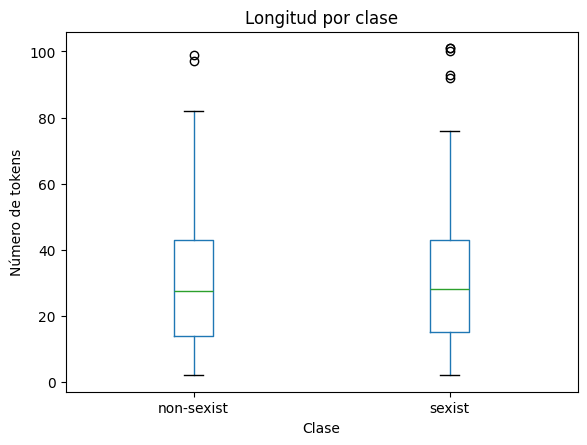

In [8]:

df_train.boxplot(column='n_tokens', by='label', grid=False)
plt.suptitle("")
plt.title("Longitud por clase")
plt.xlabel("Clase")
plt.ylabel("Número de tokens")
plt.show()


El boxplot muestra que ambas clases tienen longitudes muy similares. Las medianas están prácticamente alineadas (≈25–30 tokens) y los rangos intercuartílicos se solapan ampliamente, lo que indica que la longitud del texto no discrimina claramente entre sexist y non-sexist.

Ambas clases presentan colas derechas y outliers (textos largos cercanos a 100 tokens), ligeramente más extremos en sexist, pero poco frecuentes. En conjunto, la longitud parece ser una característica neutra, por lo que las diferencias entre clases deberán capturarse más por el contenido semántico que por la extensión del texto.

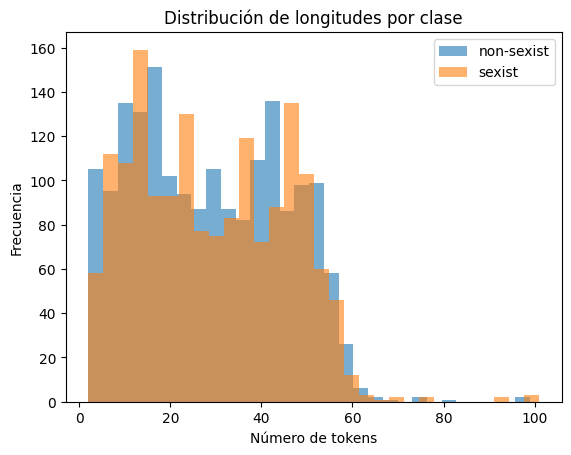

In [11]:
plt.hist(
    df_train[df_train['label'] == 'non-sexist']['n_tokens'],
    bins=30,
    alpha=0.6,
    label='non-sexist'
)

plt.hist(
    df_train[df_train['label'] == 'sexist']['n_tokens'],
    bins=30,
    alpha=0.6,
    label='sexist'
)

plt.title("Distribución de longitudes por clase")
plt.xlabel("Número de tokens")
plt.ylabel("Frecuencia")
plt.legend()
plt.show()

Este último es útil si quieres comparar directamente el solapamiento entre clases.

El histograma superpuesto muestra un alto grado de solapamiento entre ambas clases, lo que confirma que la longitud del texto no es un factor discriminativo fuerte entre sexist y non-sexist.

Ambas distribuciones se concentran principalmente entre 10 y 50 tokens, con una cola derecha similar que se extiende hasta valores cercanos a 100 tokens. Las diferencias locales de frecuencia (ligeramente más textos cortos en una clase u otra) son menores y no sistemáticas.

En conjunto, el gráfico refuerza la idea de que las diferencias entre clases deberán capturarse principalmente a través del contenido léxico y semántico, y no mediante la longitud del texto.

## 5. Análisis básico de vocabulario

In [12]:

from collections import Counter

all_tokens = []
for text in df_train['text']:
    all_tokens.extend(text.lower().split())

vocab_counter = Counter(all_tokens)
print("Tamaño del vocabulario:", len(vocab_counter))
print("Top-20 palabras:", vocab_counter.most_common(20))


Tamaño del vocabulario: 21656
Top-20 palabras: [('the', 2702), ('to', 2483), ('a', 2393), ('and', 1988), ('i', 1640), ('you', 1574), ('of', 1326), ('is', 1161), ('in', 964), ('for', 961), ('that', 915), ('women', 841), ('like', 723), ('are', 683), ('it', 676), ('not', 593), ('my', 579), ('this', 578), ('but', 577), ('on', 575)]


Borramos las stopwords y todo lo que no sea una palabra. Además, obtenemos los lemas.

In [14]:
from collections import Counter
import spacy

# Cargar modelo de spaCy en inglés
nlp = spacy.load("en_core_web_sm")

all_tokens = []

for text in df_train['text']:
    doc = nlp(text.lower())
    tokens = [
        token.lemma_
        for token in doc
        if not token.is_stop      # eliminar stopwords
        and not token.is_punct   # eliminar puntuación
        and token.is_alpha       # solo palabras
    ]
    all_tokens.extend(tokens)

vocab_counter = Counter(all_tokens)

print("Vocabulary size:", len(vocab_counter))
print("Top-20 tokens:", vocab_counter.most_common(20))


Vocabulary size: 8762
Top-20 tokens: [('woman', 1541), ('like', 775), ('man', 736), ('look', 350), ('want', 289), ('know', 288), ('think', 268), ('people', 256), ('say', 213), ('amp', 211), ('fuck', 210), ('get', 204), ('good', 194), ('girl', 189), ('need', 184), ('love', 179), ('bitch', 175), ('feminism', 171), ('go', 161), ('time', 161)]


El top-20 de tokens revela patrones semánticos muy claros y coherentes con una tarea de detección de sexismo.

En primer lugar, destacan términos de género como woman, man y girl, con woman siendo, con diferencia, el token más frecuente. Esto sugiere que gran parte del discurso del corpus gira explícitamente en torno a las mujeres, lo cual es esperable en datasets relacionados con sexismo, pero también indica un fuerte sesgo temático que los modelos pueden explotar fácilmente.

Aparecen además muchos verbos y expresiones conversacionales (like, look, want, think, know, say, get, go), lo que apunta a textos de tipo informal u opinativo (por ejemplo, comentarios en redes sociales). Esto refuerza la idea de que el corpus refleja lenguaje cotidiano, no textos formales.

La presencia de lenguaje ofensivo explícito (fuck, bitch) es especialmente relevante: estos tokens suelen ser fuertes señales predictivas para modelos de clasificación, pero también conllevan el riesgo de que el modelo dependa en exceso de insultos explícitos y tenga dificultades con casos más sutiles de sexismo.

El token feminism indica que el corpus no solo contiene ataques directos, sino también discursos ideológicos o debates, donde el sexismo puede manifestarse de forma más implícita o irónica.

Por otro lado, amp es típico de textos HTML, lo que sugiere que aún hay algo de ruido en los datos y que una limpieza adicional podría mejorar la calidad del vocabulario.

En conjunto, este top-20 muestra un vocabulario altamente informativo pero también potencialmente sesgado, donde el contenido de género domina claramente, y la detección de sexismo implícito será el verdadero reto para modelos más avanzados.

## 6. Palabras más frecuentes por clase

In [18]:

tokens_0, tokens_1 = [], []

for _, row in df_train.iterrows():
    tokens = row['text'].lower().split()
    if row['label'] == 'non-sexist':
        tokens_0.extend(tokens)
    else:
        tokens_1.extend(tokens)

print("non-sexist:", Counter(tokens_0).most_common(15))
print("sexist:", Counter(tokens_1).most_common(15))


non-sexist: [('the', 1506), ('to', 1311), ('a', 1135), ('and', 1047), ('i', 907), ('of', 746), ('you', 704), ('is', 588), ('in', 529), ('for', 521), ('that', 474), ('it', 368), ('are', 336), ('my', 333), ('like', 330)]
sexist: [('a', 1258), ('the', 1196), ('to', 1172), ('and', 941), ('you', 870), ('i', 733), ('of', 580), ('is', 573), ('women', 520), ('that', 441), ('for', 440), ('in', 435), ('like', 393), ('are', 347), ('be', 323)]


In [19]:
from collections import Counter
import spacy

# Cargar modelo spaCy en inglés
nlp = spacy.load("en_core_web_sm")

tokens_0, tokens_1 = [], []

for _, row in df_train.iterrows():
    doc = nlp(row['text'].lower())
    tokens = [
        token.lemma_
        for token in doc
        if token.is_alpha        # solo palabras
        and not token.is_stop    # sin stopwords
        and not token.is_punct
    ]

    if row['label'] == 'non-sexist':
        tokens_0.extend(tokens)
    else:
        tokens_1.extend(tokens)

print("Clase non-sexist:", Counter(tokens_0).most_common(15))
print("Clase sexist:", Counter(tokens_1).most_common(15))


Clase non-sexist: [('woman', 648), ('like', 355), ('man', 319), ('people', 162), ('know', 154), ('think', 142), ('amp', 133), ('look', 131), ('good', 110), ('want', 110), ('need', 107), ('get', 101), ('love', 96), ('fuck', 95), ('thing', 94)]
Clase sexist: [('woman', 893), ('like', 420), ('man', 417), ('look', 219), ('want', 179), ('know', 134), ('think', 126), ('feminism', 121), ('say', 120), ('fuck', 115), ('bitch', 104), ('get', 103), ('girl', 103), ('people', 94), ('feminist', 93)]


## 7. Textos muy cortos o vacíos

In [22]:

df_short=df_train[df_train['n_tokens'] < 3]
print(df_short.shape)
df_short


(5, 3)


,text,label,n_tokens
164,manspreading bros,non-sexist,2
1004,thinking https://t.co/d3XxDnMwBL,non-sexist,2
1778,bitch im....UP,non-sexist,2
2212,@sunnysmagazine BITCH,sexist,2
3286,sodomize pants,sexist,2



## 8. Conclusiones

Reflexiona:
- Balance de clases
- Elección de `max_length`
- Diferencias entre clases
- Necesidad de limpieza
